### This is part 5 and the final notebook in topic modelling series
- Here, I decide between LDA and NMF and choose LDA as my final model based on a few comparisons.

In [197]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from gensim import matutils,models
from nltk import word_tokenize
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
from gensim.corpora import Dictionary
from gensim.models.nmf import Nmf
from sklearn.decomposition import NMF
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
from gensim.corpora import Dictionary
import spacy
import re
import pickle
import string
#loading spacy -en
nlp = spacy.load(r'C:\Users\pares\AppData\Local\Continuum\anaconda3\Lib\site-packages\en_core_web_sm\en_core_web_sm-2.1.0', disable=['parser', 'ner'])
import warnings
warnings.filterwarnings("ignore")

# Evaluating the two models: LDA vs NMF?

In [44]:
#loading the cleaned data
clean_data_og = pd.read_pickle('clean_data_original.pkl')
clean_data_lemma = pd.read_pickle('clean_data_lemmatized.pkl')

In [41]:
#loading the two models
lda = models.LdaModel.load('final_lda.model')
nmf = Nmf.load('nmf11_final_')

In [46]:
#loading the corpus
corpusmm = corpora.MmCorpus('all_text_corpus.mm')

#### Our 2 final models - LDA and NMF- both are prepared using gensim and are prepared on the same training dataset which includes same terms derived from the training set. However, LDA categorized the reviews into 16 topics and NMF categorized it into 11 topics. Lets look at which model is better.

### Coherence Score

In [50]:
umass_lda = CoherenceModel(model = lda,corpus = corpusmm,coherence = "u_mass").get_coherence()
umass_nmf = CoherenceModel(model = nmf,corpus = corpusmm,coherence = "u_mass").get_coherence()

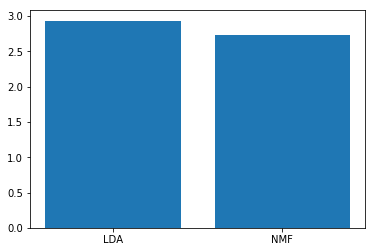

In [72]:
temp = pd.DataFrame({'Topic_Model':['LDA','NMF'],'Coherence_Score':[abs(umass_lda),abs(umass_nmf)]})
plt.bar(temp.Topic_Model,temp.Coherence_Score)
plt.show()

- The 2 models are very close as far as coherence scores go. But, here NMF slightly takes the edge since it has a lesser "umass" score.

## Topic Quality

- We can definitely compare multiple metrics, but in case of topic modelling, I feel the best way to compare is checking it on the data itself. The metrics can be used to only support the hypothesis/argument. So, lets sample a few documents and check what the two model predict. We'll have to manually read and understand how good the model actually is.

In [172]:
training,testing = np.split(clean_data_og,[int(0.7*len(clean_data_og))])
testing.reset_index(drop = True,inplace = True)

In [173]:
#these are cleaned texts, and were separted in the initial phase and have not been used for modelling
testing.head()

,id,title,review
0,375440,Instant? Fooled my guests.,These are so good I can not believe they are i...
1,375441,You could have fooled me!,I love the Idahoan roasted garlic mashed potat...
2,375442,lemon bear,I ordered the lemon flavor bear as a gift. It...
3,375444,best tea ever,I have been a tea-lover for 30 plus years. som...
4,375445,dehydrated onions are minced,"I bought this item because, unlike other optio..."


- Before going ahead with our predictions, lets import/copy all the previously created functions that we would be needing

In [252]:
dct_lda = Dictionary.from_corpus(corpusmm,id2word = lda.id2word)
dct_nmf = Dictionary.from_corpus(corpusmm,id2word = nmf.id2word)
#importing previously created stop-words
with open('stop_words_amazon', 'rb') as f:
    stop_words = pickle.load(f)
#function to clean the reviews
def clean_text(text):
    text = text.lower() #lower-casing
    text = [i for i in word_tokenize(text) if i not in stop_words] #remvoving stop-words
    doc = nlp(' '.join(text))
    text = [token.lemma_ for token in doc] #lemmatizing the reviews
    text = ' '.join(text)    
    text = re.sub(r'\d+','',text) #removing numbers
    text = text.translate(str.maketrans('','',string.punctuation)) #removing punctuation
    text = text.strip() #removing white-spaces
    return text

In [217]:
#summarized themes of topics
lda_theme = {0:'Delivery/ Order Related Issues',1:'Breakfast Food',2:'Chewing Gums/ Dog Treats',3:'Bad Products',4:'Energy Drinks/ Sports Drinks',5:'Packaging Bags',
             6:'Sweet Snacks(Chocolates)',7:'Beverages (Juices)',8:'Gifts/High Calorie Foods', 9:'Spicy Food/ Soups',10:'A Baking Recipe',11:'Pet Issues',
             12:'Tea(s)',13:'Salty Snacks(Crackers)', 14:'Hair Products/ Cat Issues', 15: 'Coffee'}
nmf_theme = {-1:'Random/ no particular topic',0:'Salty Snacks',1:'Cat Food',2:'Tea(s)',3:'Sweet Snacks',4:'Coffee Flavors',
             5:'Chocolates',6:'Oils',7:'Recipe', 8:'Coffee equipments',9:'Beverages',10:'Dog Treats/ Food'}

## Theme Predictions

- Lets sample a few documents from the testing set and see which model categorizes/ summarizes the documents better

In [292]:
#predicting LDA topic
def predict_topic(document):
    print("--------The given document reads------------")
    print("")
    print(document)
    document = clean_text(document)
    doc_vector_lda = dct_lda.doc2bow(word_tokenize(document))
    doc_vector_nmf = dct_nmf.doc2bow(word_tokenize(document))
    topic1,perc1 = sorted(lda[doc_vector_lda],key = lambda x:x[1],reverse = True)[0]
    topic2,perc2 = sorted(nmf[doc_vector_nmf],key = lambda x:x[1],reverse = True)[0]
    print("")
    print("LDA predicts this document to be talking about",'\x1b[1;31m'+ lda_theme[topic1]  +'\x1b[0m')
    print("NMF predicts this document to be talking about",'\x1b[1;34m'+ nmf_theme[topic2]  +'\x1b[0m')
    print("")

In [288]:
sample_docs = testing.sample(10)
sample_docs.reset_index(inplace = True,drop = True)

In [299]:
for i in range(len(sample_docs)):
    print("Document Summary provided by user:",sample_docs.title[i])
    print("")
    predict_topic(sample_docs.review[i])
    print("--"*60)

Document Summary provided by user: Wife loved the gumballs

--------The given document reads------------

Although it took 3 bags of the gumballs to fill up her big gumball machine, my wife loved them :)  I am glad I got the 12 pack instead of just getting a couple and not having enough.

LDA predicts this document to be talking about Packaging Bags
NMF predicts this document to be talking about Salty Snacks

------------------------------------------------------------------------------------------------------------------------
Document Summary provided by user: Best K-Cup dispenser ever!

--------The given document reads------------

I absolutely love this under cabinet K-cup dispenser. It gives me more counter room and is almost hidden. What a great idea! I found it on Amazon.com and am amazed each time I use it. My husband installed it for me quickly and easily. It came with screws and it is wonderful. It iss easy to pull down to choose the K-cup I or my guests want, and just as eas

## Conclusion

In my opinion, LDA does a better job here. Both the models have been good picking the topics for majority of documents but LDA takes a slight edge, so I'm gonna use it as my final model here. And now lets deploy this model.

#### ------ Analysis End-------------